Parameter Heatmap
==========

This tutorial will show how to optimize strategies with multiple parameters and how to examine and reason about optimization results.
It is assumed you're already familiar with
[basic _backtesting.py_ usage](https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html).

First, let's again import our helper moving average function.
In practice, one should use functions from an indicator library, such as
[TA-Lib](https://github.com/mrjbq7/ta-lib) or
[Tulipy](https://tulipindicators.org).

In [1]:
from minitrade.backtest.core.test import SMA

/Users/ww/workspace/minitrade/minitrade/backtest/core/_plotting.py:40: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Our strategy will be a similar moving average cross-over strategy to the one in
[Quick Start User Guide](https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html),
but we will use four moving averages in total:
two moving averages whose relationship determines a general trend
(we only trade long when the shorter MA is above the longer one, and vice versa),
and two moving averages whose cross-over with daily _close_ prices determine the signal to enter or exit the position.

In [2]:
from minitrade.backtest import Strategy
from minitrade.backtest.core.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        
    def next(self):
        
        if not self.position():
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1[-1] > self.sma2[-1]:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position().is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position().is_short and
                crossover(self.data.Close, self.sma_exit)):
                
                self.position().close()

It's not a robust strategy, but we can optimize it.

[Grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search)
is an exhaustive search through a set of specified sets of values of hyperparameters. One evaluates the performance for each set of parameters and finally selects the combination that performs best.

Let's optimize our strategy on Google stock data using _randomized_ grid search over the parameter space, evaluating at most (approximately) 200 randomly chosen combinations:

In [3]:
%%time 

from minitrade.backtest import Backtest
from minitrade.backtest.core.test import GOOG


backtest = Backtest(GOOG, Sma4Cross, commission=.002)

stats, heatmap = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

/Users/ww/workspace/minitrade/minitrade/backtest/core/backtesting.py:1518: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 44.9 s, sys: 194 ms, total: 45 s
Wall time: 45.2 s


Notice `return_heatmap=True` parameter passed to
[`Backtest.optimize()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize).
It makes the function return a heatmap series along with the usual stats of the best run.
`heatmap` is a pandas Series indexed with a MultiIndex, a cartesian product of all permissible (tried) parameter values.
The series values are from the `maximize=` argument we provided.

In [4]:
heatmap

n1   n2   n_enter  n_exit
20   60   15       10        10102.86700
     80   15       10         9864.21924
     100  15       10        11003.21764
30   40   20       15        11771.28610
          25       15        16178.54842
                                ...     
100  200  15       10        13118.24766
          20       10        11308.46180
                   15        16350.94380
          25       10         8991.55294
          30       10         9953.07010
Name: Equity Final [$], Length: 177, dtype: float64

This heatmap contains the results of all the runs,
making it very easy to obtain parameter combinations for e.g. three best runs:

In [5]:
heatmap.sort_values().iloc[-3:]

n1   n2   n_enter  n_exit
100  120  15       10        18159.06414
     160  20       15        19216.54456
50   160  20       15        19565.69222
Name: Equity Final [$], dtype: float64

But we use vision to make judgements on larger data sets much faster.
Let's plot the whole heatmap by projecting it on two chosen dimensions.
Say we're mostly interested in how parameters `n1` and `n2`, on average, affect the outcome.

In [6]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2,40,60,80,100,120,140,160,180,200
n1,,,,,,,,,
20,NaN,10102.867000,9864.219240,11003.217640,NaN,NaN,NaN,NaN,NaN
30,13974.91726,11696.318673,11757.991340,15092.994270,13152.243360,11518.686895,11271.353850,11384.550965,10649.052688
40,NaN,13666.448095,NaN,7549.099980,10629.479030,12860.993870,11405.291153,10863.807380,10658.139865
50,NaN,8383.464960,10180.502548,10563.790150,9081.947013,14272.265500,13575.860855,11383.464993,10053.468620
60,NaN,NaN,9232.415117,8046.485900,10838.454280,12876.589427,10312.954633,9427.545100,9555.402033
70,NaN,NaN,14712.143280,7192.892540,10403.014630,10065.279860,8293.733687,9895.782090,9360.478292
80,NaN,NaN,NaN,10863.108515,7721.243967,9139.946300,8813.949990,10414.656200,8908.486500
90,NaN,NaN,NaN,8958.143200,9538.050067,9884.415550,9685.919510,11343.643830,8806.572300
100,NaN,NaN,NaN,NaN,11253.156553,7101.260447,11323.427430,10163.321700,11944.455260


Let's plot this table using the excellent [_Seaborn_](https://seaborn.pydata.org) package:

<Axes: xlabel='n2', ylabel='n1'>

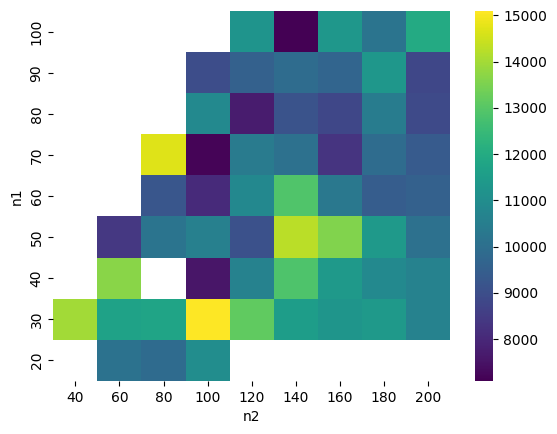

In [7]:
%matplotlib inline

import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis')

We see that, on average, we obtain the highest result using trend-determining parameters `n1=40` and `n2=60`,
and it's not like other nearby combinations work similarly well — in our particular strategy, this combination really stands out.

Since our strategy contains several parameters, we might be interested in other relationships between their values.
We can use
[`backtesting.lib.plot_heatmaps()`](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#backtesting.lib.plot_heatmaps)
function to plot interactive heatmaps of all parameter combinations simultaneously.

In [8]:
from minitrade.backtest.core.lib import plot_heatmaps


plot_heatmaps(heatmap, agg='mean')

Column(id='1271', ...)

## Model-based optimization

Above, we used _randomized grid search_ optimization method. Any kind of grid search, however, might be computationally expensive for large data sets. In the follwing example, we will use
[_scikit-optimize_](https://scikit-optimize.github.io)
package to guide our optimization better informed using forests of decision trees.
The hyperparameter model is sequentially improved by evaluating the expensive function (the backtest) at the next best point, thereby hopefully converging to a set of optimal parameters with as few evaluations as possible.

So, with `method="skopt"`:

In [9]:
%%capture

# Use the forked version from https://github.com/dodid/scikit-optimize.git, which contains numpy and scikit-learn fixes.
# ! pip install scikit-optimize  # This is a run-time dependency

In [10]:
%%time

stats_skopt, heatmap, optimize_result = backtest.optimize(
    n1=[10, 100],      # Note: For method="skopt", we
    n2=[20, 200],      # only need interval end-points
    n_enter=[10, 40],
    n_exit=[10, 30],
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=200,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

Backtest.optimize:   0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 28 s, sys: 180 ms, total: 28.2 s
Wall time: 28.3 s


In [11]:
heatmap.sort_values().iloc[-3:]

n1  n2   n_enter  n_exit
35  98   28       24        28365.14512
68  96   29       24        28424.01724
44  134  39       27        29941.37700
Name: Equity Final [$], dtype: float64

Notice how the optimization runs somewhat slower even though `max_tries=` is the same. But that's due to the sequential nature of the algorithm and should actually perform rather comparably even in cases of _much larger parameter spaces_ where grid search would effectively blow up, but likely (hopefully) reaching a better local optimum than a randomized search would.
A note of warning, again, to take steps to avoid
[overfitting](https://en.wikipedia.org/wiki/Overfitting)
insofar as possible.

Understanding the impact of each parameter on the computed objective function is easy in two dimensions, but as the number of dimensions grows, partial dependency plots are increasingly useful.
[Plotting tools from _scikit-optimize_](https://scikit-optimize.github.io/stable/modules/plots.html)
take care of many of the more mundane things needed to make good and informative plots of the parameter space:

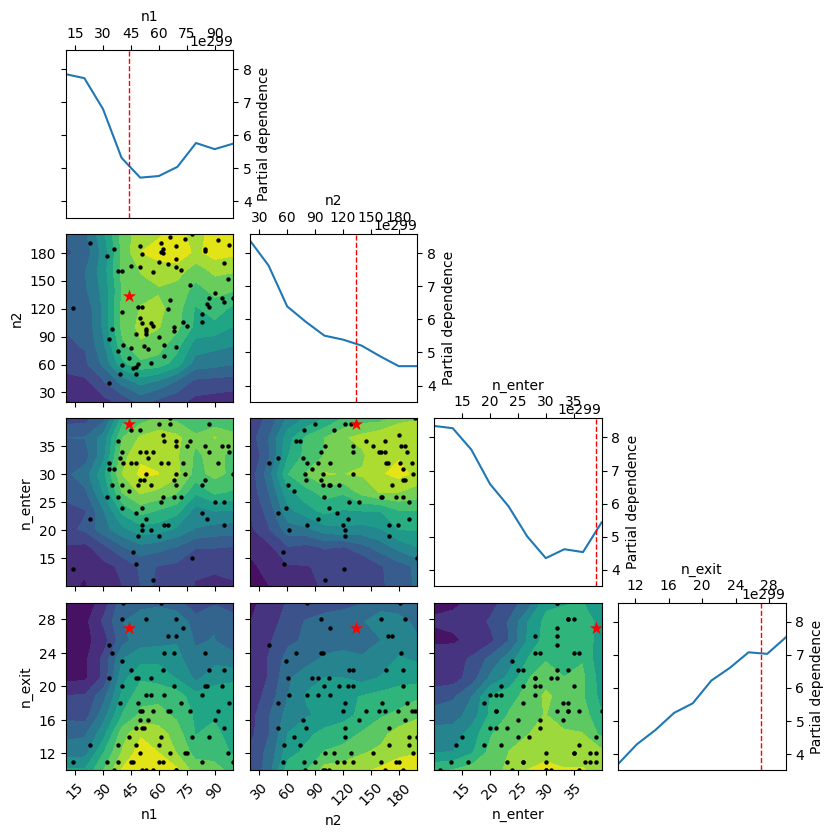

In [12]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

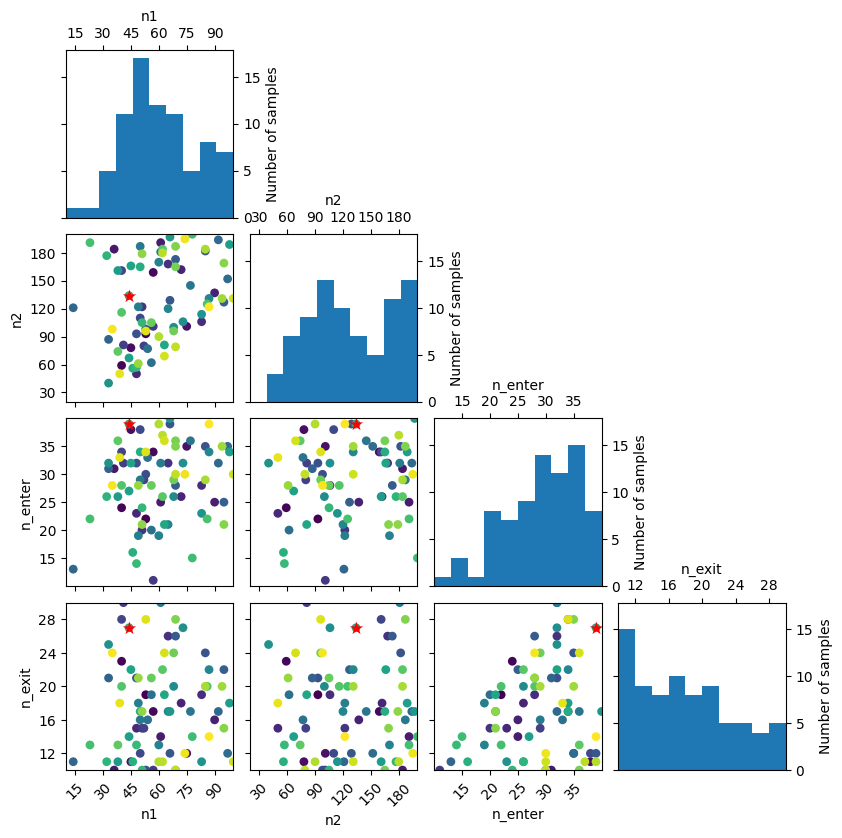

In [13]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(optimize_result, bins=10)

Learn more by exploring further
[examples](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#tutorials)
or find more framework options in the
[full API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules).